In [1]:
import random
from typing import Callable, Iterable

import datasets
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from transformers.optimization import get_linear_schedule_with_warmup
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
teacher_model_name = "sentence-transformers/paraphrase-distilroberta-base-v2"
student_model_name = "xlm-roberta-base"

In [3]:
teacher_tokenizer = AutoTokenizer.from_pretrained(teacher_model_name)
student_tokenizer = AutoTokenizer.from_pretrained(student_model_name)

In [4]:
seed = 10

random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
def is_valid_len(d):
    d = d["translation"]
    return len(d["en"]) > 30 and len(d["en"]) < 64 and len(d["hi"]) > 20 and len(d["hi"]) < 64

In [6]:
dataset = datasets.load_dataset("cfilt/iitb-english-hindi", split="train")

dataset = dataset.filter(lambda x: True if is_valid_len(x) and (random.random() > 0.8) else False)

len(dataset), dataset[0]

Using custom data configuration cfilt--iitb-english-hindi-911387c6837f8b91
Reusing dataset parquet (/home/utsav/.cache/huggingface/datasets/cfilt___parquet/cfilt--iitb-english-hindi-911387c6837f8b91/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8)
Parameter 'function'=<function <lambda> at 0x7f07149691f0> of the transform datasets.arrow_dataset.Dataset.filter@2.0.1 couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
Loading cached processed dataset at /home/utsav/.cache/huggingface/datasets/cfilt___parquet/cfilt--iitb-english-hindi-911387c6837f8b91/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8

(133571,
 {'translation': {'en': 'The default plugin layout for the top panel',
   'hi': 'ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका'}})

In [7]:
dataset[0]

{'translation': {'en': 'The default plugin layout for the top panel',
  'hi': 'ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका'}}

In [8]:
%%time

teacher_tokenized_en = teacher_tokenizer([data["translation"]["en"] for data in dataset],
                                         max_length=64, padding="max_length",
                                         truncation=True, verbose=True)

student_tokenized_en = student_tokenizer([data["translation"]["en"] for data in dataset],
                                         max_length=64, padding="max_length",
                                         truncation=True, verbose=True)

student_tokenized_hi = student_tokenizer([data["translation"]["hi"] for data in dataset],
                                         max_length=64, padding="max_length",
                                         truncation=True, verbose=True)

CPU times: user 59.8 s, sys: 8.4 s, total: 1min 8s
Wall time: 31.1 s


In [9]:
class EnHiDataset:
    def __init__(self, teacher_en_tokens: dict, student_en_tokens: dict, student_hi_tokens: dict):
        self.teacher_en_tokens = teacher_en_tokens
        self.student_en_tokens = student_en_tokens
        self.student_hi_tokens = student_hi_tokens

    def __getitem__(self, ix: int) -> dict[str, torch.tensor]:
        return {
            "teacher_en_input_ids": torch.tensor(self.teacher_en_tokens["input_ids"][ix], dtype=torch.long),
            "teacher_en_attention_mask": torch.tensor(self.teacher_en_tokens["attention_mask"][ix], dtype=torch.long),
            "student_en_input_ids": torch.tensor(self.student_en_tokens["input_ids"][ix], dtype=torch.long),
            "student_en_attention_mask": torch.tensor(self.student_en_tokens["attention_mask"][ix], dtype=torch.long),
            "student_hi_input_ids": torch.tensor(self.student_hi_tokens["input_ids"][ix], dtype=torch.long),
            "student_hi_attention_mask": torch.tensor(self.student_hi_tokens["attention_mask"][ix], dtype=torch.long)
        }

    def __len__(self) -> int:
        return len(self.teacher_en_tokens["input_ids"])

In [10]:
%%time

dataset = EnHiDataset(teacher_tokenized_en, student_tokenized_en, student_tokenized_hi)

CPU times: user 0 ns, sys: 7.53 ms, total: 7.53 ms
Wall time: 7.53 ms


In [11]:
len(dataset)

133571

In [12]:
train_ratio = 0.8
n_total = len(dataset)
n_train = int(n_total * train_ratio)
n_val = n_total - n_train

train_dataset, val_dataset = random_split(dataset, [n_train, n_val])

batch_size = 2
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [13]:
# next(iter(train_dataloader))

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [15]:
def mean_pool(token_embeds: torch.tensor, attention_mask: torch.tensor) -> torch.tensor:
    in_mask = attention_mask.unsqueeze(-1).expand(token_embeds.size()).float()
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(in_mask.sum(1), min=1e-9)
    return pool

In [16]:
teacher_model = AutoModel.from_pretrained(teacher_model_name).to(device)
student_model = AutoModel.from_pretrained(student_model_name).to(device)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
d = next(iter(train_dataloader))

In [18]:
teacher_model_out = teacher_model(d["teacher_en_input_ids"].to(device),
                                  d["teacher_en_attention_mask"].to(device))

In [19]:
student_en_model_out = student_model(d["student_en_input_ids"].to(device),
                                     d["student_en_attention_mask"].to(device))

student_hi_model_out = student_model(d["student_hi_input_ids"].to(device),
                                     d["student_hi_attention_mask"].to(device))

In [20]:
teacher_model_out.last_hidden_state.shape

torch.Size([2, 64, 768])

In [21]:
student_en_model_out.last_hidden_state.shape

torch.Size([2, 64, 768])

In [22]:
teacher_en_pooled = mean_pool(teacher_model_out.last_hidden_state, d["teacher_en_attention_mask"].to(device))

In [23]:
student_en_pooled = mean_pool(student_en_model_out.last_hidden_state, d["student_en_attention_mask"].to(device))
student_hi_pooled = mean_pool(student_hi_model_out.last_hidden_state, d["student_hi_attention_mask"].to(device))

In [24]:
err = (teacher_en_pooled - student_en_pooled) ** 2 + (teacher_en_pooled - student_hi_pooled) ** 2

In [25]:
err.shape

torch.Size([2, 768])

In [26]:
torch.nn.MSELoss()(student_en_pooled, teacher_en_pooled)

tensor(0.7211, device='cuda:0', grad_fn=<MseLossBackward0>)

In [27]:
torch.nn.MSELoss()(student_hi_pooled, teacher_en_pooled)

tensor(0.7246, device='cuda:0', grad_fn=<MseLossBackward0>)

In [28]:
#  optimizer, lr, num_warmup steps have been picked from the paper
optimizer = torch.optim.Adam(student_model.parameters(), lr=2e-5)
total_steps = len(train_dataset) // batch_size
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps - warmup_steps)

loss_fn = torch.nn.MSELoss()

In [29]:
def get_train_step_fn(teacher_model: torch.nn.Module, student_model: torch.nn.Module,
                      optimizer: torch.optim.Optimizer,
                      scheduler: torch.optim.lr_scheduler.LambdaLR,
                      loss_fn: torch.nn.CrossEntropyLoss):

    def train_step_fn(d: torch.tensor) -> float:
        student_model.train()

        teacher_model_out = teacher_model(d["teacher_en_input_ids"].to(device),
                                          d["teacher_en_attention_mask"].to(device))
        teacher_en_pooled = mean_pool(teacher_model_out.last_hidden_state,
                                      d["teacher_en_attention_mask"].to(device))

        student_en_model_out = student_model(d["student_en_input_ids"].to(device),
                                     d["student_en_attention_mask"].to(device))
        student_hi_model_out = student_model(d["student_hi_input_ids"].to(device),
                                             d["student_hi_attention_mask"].to(device))
        student_en_pooled = mean_pool(student_en_model_out.last_hidden_state,
                                      d["student_en_attention_mask"].to(device))
        student_hi_pooled = mean_pool(student_hi_model_out.last_hidden_state,
                                      d["student_hi_attention_mask"].to(device))
        
        loss = (loss_fn(student_en_pooled, teacher_en_pooled) +
                loss_fn(student_hi_pooled, teacher_en_pooled)) / 2

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        return loss.item()

    return train_step_fn


def get_val_step_fn(teacher_model: torch.nn.Module, student_model: torch.nn.Module,
                    loss_fn: torch.nn.CrossEntropyLoss):

    def val_step_fn(d: torch.tensor) -> float:
        student_model.eval()

        teacher_model_out = teacher_model(d["teacher_en_input_ids"].to(device),
                                          d["teacher_en_attention_mask"].to(device))
        teacher_en_pooled = mean_pool(teacher_model_out.last_hidden_state,
                                      d["teacher_en_attention_mask"].to(device))

        student_en_model_out = student_model(d["student_en_input_ids"].to(device),
                                     d["student_en_attention_mask"].to(device))
        student_hi_model_out = student_model(d["student_hi_input_ids"].to(device),
                                             d["student_hi_attention_mask"].to(device))
        student_en_pooled = mean_pool(student_en_model_out.last_hidden_state,
                                      d["student_en_attention_mask"].to(device))
        student_hi_pooled = mean_pool(student_hi_model_out.last_hidden_state,
                                      d["student_hi_attention_mask"].to(device))
        
        loss = (loss_fn(student_en_pooled, teacher_en_pooled) +
                loss_fn(student_hi_pooled, teacher_en_pooled)) / 2

        return loss.item()

    return val_step_fn


def mini_batch(
    dataloader: DataLoader, step_fn: Callable[torch.tensor, torch.tensor], is_training: bool = True
) -> tuple[np.array, list[float]]:

    mini_batch_losses = []

    if is_training:
        print("\nTraining ...")
    else:
        print("\nValidating ...")
    n_steps = len(dataloader)
    for i, data in enumerate(dataloader):
        loss = step_fn(data)
        mini_batch_losses.append(loss)
        if i % (batch_size * 1000) == 0:
            print(f"step {i:>5}/{n_steps}, loss = {loss: .3f}")

    return np.mean(mini_batch_losses), mini_batch_losses

In [30]:
%%time

n_epochs = 1

train_step_fn = get_train_step_fn(teacher_model, student_model, optimizer, scheduler, loss_fn)
val_step_fn = get_val_step_fn(teacher_model, student_model, loss_fn)

train_losses, train_mini_batch_losses = [], []
val_losses, val_mini_batch_losses = [], []

for epoch in range(1, n_epochs + 1):
    train_loss, _train_mini_batch_losses = mini_batch(train_dataloader, train_step_fn)
    train_mini_batch_losses += _train_mini_batch_losses
    train_losses.append(train_loss)

    with torch.no_grad():
        val_loss, _val_mini_batch_losses = mini_batch(val_dataloader, val_step_fn, is_training=False)
        val_mini_batch_losses += _val_mini_batch_losses
        val_losses.append(val_loss)


Training ...
step     0/53428, loss =  0.733
step  2000/53428, loss =  0.263
step  4000/53428, loss =  0.256
step  6000/53428, loss =  0.271
step  8000/53428, loss =  0.242
step 10000/53428, loss =  0.214
step 12000/53428, loss =  0.217
step 14000/53428, loss =  0.222
step 16000/53428, loss =  0.202
step 18000/53428, loss =  0.198
step 20000/53428, loss =  0.168
step 22000/53428, loss =  0.242
step 24000/53428, loss =  0.145


KeyboardInterrupt: 

In [38]:
with torch.no_grad():
    val_loss, _val_mini_batch_losses = mini_batch(val_dataloader, val_step_fn, is_training=False)
    val_mini_batch_losses += _val_mini_batch_losses
    val_losses.append(val_loss)


Validating ...
step     0/13358, loss =  0.224
step  2000/13358, loss =  0.211


KeyboardInterrupt: 

In [39]:
train_losses, val_losses

([], [])

In [32]:
student_model.save_pretrained("models/student_mutli_enhi.pt")

In [33]:
# running mean of the mini batch losses

window_size = 32

train_mb_running_loss = []
for i in range(len(train_mini_batch_losses)-window_size):
    train_mb_running_loss.append(np.mean(train_mini_batch_losses[i:i+window_size]))

val_mb_running_loss = []
for i in range(len(val_mini_batch_losses)-window_size):
    val_mb_running_loss.append(np.mean(val_mini_batch_losses[i:i+window_size]))

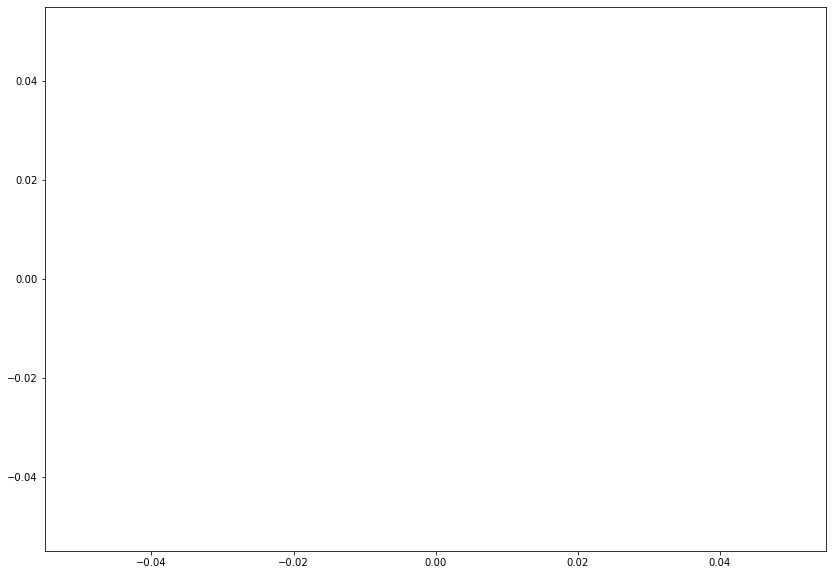

In [34]:
fix, ax = plt.subplots(figsize=(14, 10))
ax.plot(range(len(train_mb_running_loss)), train_mb_running_loss);

In [66]:
def compare_reranking(
    tokenizer: AutoTokenizer, model: AutoModel, device: str, query: str, corpus: list[str]
) -> None:
    
    query_embed = \
    mean_pool(model(
        **tokenizer(query, return_tensors="pt").to(device)
    ).last_hidden_state,
              tokenizer(query, return_tensors="pt")["attention_mask"].to(device)
             )

    corpus_last_hidden_state = model(
        **tokenizer(corpus, max_length=64, padding=True,
                    truncation=True, return_tensors="pt").to(device)
    ).last_hidden_state
    corpus_embeds = mean_pool(corpus_last_hidden_state,
                              tokenizer(
                                  corpus, max_length=64, padding=True,
                                  truncation=True, return_tensors="pt"
                              )["attention_mask"].to(device)
                             )

    scores = torch.nn.CosineSimilarity()(query_embed, corpus_embeds)
    
    print(f"Query - {query}\n---")
    scores = scores.cpu().detach().numpy()
    scores_ix = np.argsort(scores)[::-1]
    for ix in scores_ix:
        print(f"{scores[ix]: >.2f}\t{corpus[ix]}")

In [74]:
original_student_model = AutoModel.from_pretrained(student_model_name)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [67]:
query = "Who let the dogs out"

corpus = [
    "A frog jumped in the pond",
    "My car broke down last night",
    "किसने कुत्तों को खुला छोड़ा",
    "Where are my dogs?",
    "Are the dogs outside?",
    "मेरी कार टूट गई",
    "I wonder if they have reached home",
    "मुझे आश्चर्य है कि क्या वे घर पहुंच गए हैं"
]

In [75]:
compare_reranking(student_tokenizer, student_model, "cuda", query, corpus)

Query - My car broke down on the highway
---
0.95	मेरी कार हाईवे पर खराब हो गई
0.94	My car broke down last night
0.91	मेरी कार टूट गई
0.75	The roads on the highway were bad.
0.27	I wonder if they have reached home
0.25	मुझे आश्चर्य है कि क्या वे घर पहुंच गए हैं
0.22	किसने कुत्तों को खुला छोड़ा
0.20	Where are my dogs?
0.11	Are the dogs outside?


In [76]:
compare_reranking(student_tokenizer, original_student_model, "cpu", query, corpus)

Query - My car broke down on the highway
---
1.00	The roads on the highway were bad.
1.00	My car broke down last night
1.00	मेरी कार हाईवे पर खराब हो गई
1.00	मुझे आश्चर्य है कि क्या वे घर पहुंच गए हैं
1.00	I wonder if they have reached home
1.00	Are the dogs outside?
0.99	किसने कुत्तों को खुला छोड़ा
0.99	Where are my dogs?
0.99	मेरी कार टूट गई


In [77]:
query = "My car broke down on the highway"

corpus = [
    "The roads on the highway were bad.",
    "My car broke down last night",
    "किसने कुत्तों को खुला छोड़ा",
    "Where are my dogs?",
    "Are the dogs outside?",
    "मेरी कार टूट गई",
    "मेरी कार हाईवे पर खराब हो गई",
    "I wonder if they have reached home",
    "मुझे आश्चर्य है कि क्या वे घर पहुंच गए हैं"
]

In [78]:
compare_reranking(student_tokenizer, student_model, "cuda", query, corpus)

Query - My car broke down on the highway
---
0.95	मेरी कार हाईवे पर खराब हो गई
0.94	My car broke down last night
0.91	मेरी कार टूट गई
0.75	The roads on the highway were bad.
0.27	I wonder if they have reached home
0.25	मुझे आश्चर्य है कि क्या वे घर पहुंच गए हैं
0.22	किसने कुत्तों को खुला छोड़ा
0.20	Where are my dogs?
0.11	Are the dogs outside?


In [79]:
compare_reranking(student_tokenizer, original_student_model, "cpu", query, corpus)

Query - My car broke down on the highway
---
1.00	The roads on the highway were bad.
1.00	My car broke down last night
1.00	मेरी कार हाईवे पर खराब हो गई
1.00	मुझे आश्चर्य है कि क्या वे घर पहुंच गए हैं
1.00	I wonder if they have reached home
1.00	Are the dogs outside?
0.99	किसने कुत्तों को खुला छोड़ा
0.99	Where are my dogs?
0.99	मेरी कार टूट गई
